## Project: **Road lane and Vehicle Detection -- using OpenCV Python** 

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


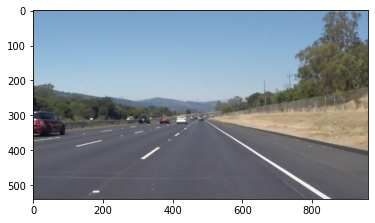

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):

    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):

    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):    

    imshape = img.shape
    left_lines = []
    right_lines = []
    left_lines_aligned = []
    right_lines_aligned = []
    left_m = []
    left_b = []
    right_m = []
    right_b = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            b = y1 - (m * x1)
            if m < 0: left_lines.append((m,b)) 
            if m > 0: right_lines.append((m,b))                  
    left_m = [line[0] for line in left_lines]
    left_m_avg = np.mean(left_m)
    left_m_std = np.std(left_m)
    
    for line in left_lines:
        if abs(line[0] - left_m_avg) < left_m_std:
            left_lines_aligned.append(line)
    if len(left_lines_aligned) > 0:
        left_m = [line[0] for line in left_lines_aligned]
        ml = np.mean(left_m)
        left_b = [line[1] for line in left_lines_aligned]
        bl = np.mean(left_b)
    else:
        ml = left_m_avg
        left_b = [line[1] for line in left_lines]
        bl = np.mean(left_b)
    
    right_m = [line[0] for line in right_lines]
    right_m_avg = np.mean(right_m)
    right_m_std = np.std(right_m)
   
    for line in right_lines:
        if abs(line[0] - right_m_avg) < right_m_std:
            right_lines_aligned.append(line)            
    if len(right_lines_aligned) > 0:
        right_m = [line[0] for line in right_lines_aligned]
        mr = np.mean(right_m)
        right_b = [line[1] for line in right_lines_aligned]
        br = np.mean(right_b)
    else:
        mr = right_m_avg
        right_b = [line[1] for line in right_lines]
        br = np.mean(right_b)

    smooth_fact = 0.8
    if (abs(ml) < 1000):
        if (previous_lines[0] != 0):
            ml = previous_lines[0]*smooth_fact + ml*(1-smooth_fact)
            bl = previous_lines[1]*smooth_fact + bl*(1-smooth_fact)
    elif (previous_lines[0] != 0):
        ml = previous_lines[0]
        bl = previous_lines[1]
        
    if (abs(mr) < 1000):      
        if (previous_lines[2] != 0):
            mr = previous_lines[2]*smooth_fact + mr*(1-smooth_fact)
            br = previous_lines[3]*smooth_fact + br*(1-smooth_fact)
    elif (previous_lines[2] != 0):
        mr = previous_lines[2]
        br = previous_lines[3]
            
                
    x1l = int((bl - imshape[0]) / (-1 * ml))
    y1l = imshape[0]    
    x2l = int((bl - 6*imshape[0]/10) / (-1 * ml))
    y2l = int(6*imshape[0]/10)      
        
    x1r = int((br - 6*imshape[0]/10) / (-1 * mr))
    y1r = int(6*imshape[0]/10)    
    x2r = int((br - imshape[0]) / (-1 * mr))
    y2r = imshape[0]      
        
    if (x2l < x1r):
        cv2.line(img, (x1l, y1l), (x2l, y2l), [0, 255, 0], thickness) 
        cv2.line(img, (x1r, y1r), (x2r, y2r), [0, 0, 255], thickness)
       
    previous_lines[0] = ml
    previous_lines[1] = bl
    previous_lines[2] = mr
    previous_lines[3] = br               
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=0.6, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



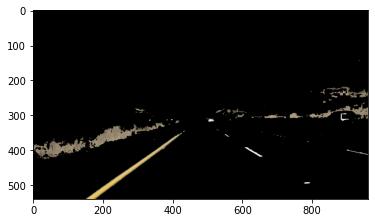

In [5]:
img = mpimg.imread('test_images/solidYellowCurve.jpg')

hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
color_mask = cv2.bitwise_or(mask_white, mask_yellow)
masked_img = np.copy(img)
masked_img[color_mask == 0] = [0,0,0]

plt.imshow(masked_img)

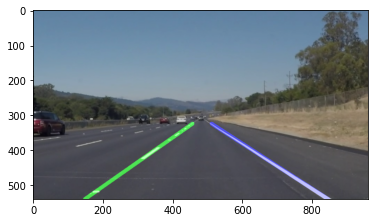

In [6]:
previous_lines = [0, 0, 0, 0]
def lane_finding_pipeline(img): 
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_white = cv2.inRange(img, (200,200,200), (255, 255, 255))
    mask_yellow = cv2.inRange(hsv_img, (15,60,20), (25, 255, 255))
    color_mask = cv2.bitwise_or(mask_white, mask_yellow)
    masked_img = np.copy(img)
    masked_img[color_mask == 0] = [0,0,0]
    
    gray_img = grayscale(masked_img)
    kernel_size = 5
    blurred_gray_img = gaussian_blur(gray_img, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges_from_img = canny(blurred_gray_img, low_threshold, high_threshold)

    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(4*imshape[1]/9, 6*imshape[0]/10), (5*imshape[1]/9, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_from_img, vertices)

    rho = 2
    theta = np.pi/180 
    threshold = 15
    min_line_len = 10 
    max_line_gap = 5    
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    overlay_img = weighted_img(line_img, img)
    
    return overlay_img


img_list = os.listdir("test_images/")

img = mpimg.imread('test_images/solidWhiteRight.jpg')
img_out = lane_finding_pipeline(img)
plt.imshow(img_out)
previous_lines = [0, 0, 0, 0]

## Test on Videos

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    result = lane_finding_pipeline(image)
    return result

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
previous_lines = [0, 0, 0, 0]

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 16 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Testing on another video

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
previous_lines = [0, 0, 0, 0]

t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 45.4 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Testing on another video

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 33.6 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))